In [9]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
%pip install -qU "langchain[openai]"
%pip install -qU langchain-chroma


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Setup

First we instantiate LangSmith for tracing, as well as OpenAI. getpass is used for a more secure api key input

In [2]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [6]:
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

Enter API key for OpenAI:  ········


Here we initialize our chat model, our embeddings function, as well as our vector database 

In [10]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma 

llm = init_chat_model("gpt-5-nano", model_provider="openai")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db"
)

We are building an app that answers question about a website's content, specifically [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) by Lilian Wang. We can create a simple RAG pipeline to do so:

In [15]:
import bs4
from langchain import hub 
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog 
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), 
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Index chunks 
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull('rlm/rag-prompt')

# define state for application 
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# define application steps

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs} 

def generate(state: State): 
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content} 

# compile application and test 
graph_builder = StateGraph(State).add_sequence([retrieve, generate]) 
graph_builder.add_edge(START, "retrieve") 
graph = graph_builder.compile()

In [17]:
response = graph.invoke({"question": "What is Task Decomposition"}) 
print(response["answer"])

Task decomposition is the process of breaking a complex task into smaller, more manageable steps or subgoals. It can be performed by an LLM with simple prompts, by task-specific instructions, or with human input. Techniques like Chain of Thought and Tree of Thoughts operationalize this by generating stepwise or branching sub-tasks to plan and execute the overall task.


Above was a simple implementation, but we can further breakdown RAG into 5 steps: 

Indexing

1. Load: First we need to load our data. This is done with document loaders.
2. Split: Text splitters break large documents into smaller chunks. This is useful for both indexing data and also passing it into the model, as large chunks are hard to search over and also won't fix the models context window (max amount of text a model can take).
3. Store: We need somewhere to store and index our splits in order for them to be searched over later. This is typically done using a VectorStore and Embeddings model.

Retrieval and generation

4. Retrieve: Given a user input , relevant splits are retrieved from storage using a Retriever
5. Generate: An LLM produces a prompt including both the question and the retrieved data



Lets start with indexing 

To first load the blog post contents we will use **DocumentLoaders** which are objects that load in data from a source and return a list of **Document** objects. 

In this case of a blog we will use **WebBaseLoader** which allows us to load HTML from web URLs and **BeautifulSoup** to parse it to text. We can customize the way we parse HTML by passing in parameters into the **BeautifulSoup** parser through (bs_kwargs) so now only HTML tags with "post-content", "post-title", "post-header" are relevant so remove all the others

In [18]:
import bs4 
from langchain_community.document_loaders import WebBaseLoader # document loader that loads and parses HTML

# keep post content, title , and header from HTML
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()
assert len(docs) == 1
print(f"Total Characters: {len(docs[0].page_content)}")

Total Characters: 43047


In [19]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


Splitting Documents

Our document is over 42k characters long and exceeds the context window, even for models that can fit these characters, they would struggle to find information within very long inputs.

To handle this we split the **Document** into chunks for embedding and vector storage which helps us retrieve only the most relevant parts of the blog at a time. (embeddings is a way to turn text into numerical representations for the computer to understand) 

RecursiveTextSplitter will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the reccomended splitter for generic text use cases.

In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, #chunk size (characters)
    chunk_overlap=200, #chunk overlap (characters)
    add_start_index=True # track index in original document
)
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents")

Split blog post into 63 sub-documents


Storing Documents

We now need to index our 63 sub-docs so that we will be able to search over them during runtime. Our approach is to embed the contents of each document split and insert these embeddings into a vector store. Given an input query we can then use vector search to retrieve relevant documents. We can do this in a single commmand

In [23]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['abbe4b0a-a6e9-4064-9a60-f9f414ae7842', '00fe3376-68e3-4b8e-b755-b42853db72ae', '61266583-0272-44cd-92c5-700b014a94f2']


Retrieval and Generation

Now lets test our pipeline. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes retrieved documents and initial question to the model and returns an answer.

In [25]:
from langchain import hub 

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
# pulling prompt from api, useful because its reusable and we dont have to maintain them ourselves
prompt = hub.pull("rlm/rag-prompt")

example_message = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"} 
).to_messages()

assert len(example_message) == 1
print(example_message[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Finally we will use LangGraph to tie together retrieval and generation into a single application. This is useful because:

* We can define our application logic once and it supports multiple invocation modes
* We get streamlined deployments through LangGraph Platform
* LangSmith will automatically trace the steps of our application together
* We can add key feautures like persistence and human-in-the-loop approval with minimal code changes

To use it we need to define 3 things:

1. The state of our application
2. The nodes of our application ( application steps )
3. The "control flow" of our application ( the ordering of steps ) 

State

The **state** of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically TypedDict, but also a Pydantic BaseModel

For simple RAG we can just track the input question, retrieved context, and generated answer

In [27]:
from langchain_core.documents import Document 
from typing_extensions import List, TypedDict

class State(TypedDict): 
    question: str
    context: List[Document]
    answer: str

Nodes ( application steps )

We will start with a simple sequence of retrieval and generation. 

Our retrieval step runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

In [29]:
def retrieve(state:State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state:State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context":docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content} 

Control Flow

Finally we compile our application into a single **graph** object. Here we are just connecting the retrieval and generation steps into a single sequence. 

In [33]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

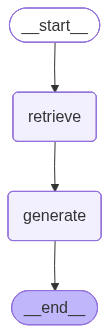

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='c1ac3bc9-d5e2-4d81-8045-8c98f7be96d3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

Query Analysis 

We can add another node in order to rewrite queries. This is benficial because it can reduce irrelevant language, and optimize the user query. We will add metadata to our document in our vector store just to illustrate how it works. 

In [40]:
total_documents = len(all_splits)
third = total_documents // 3 

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning" 
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

We need to update the documents in our vector store. We will use **InMemoryVectorStore** and some of its features like **metadata filtering**.

In [41]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Now we will define a schema for our search query. We will use a structured output for this purpose. Our query will be defined as containing a string query and a document section.

In [43]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search Query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query",
    ]

In [44]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

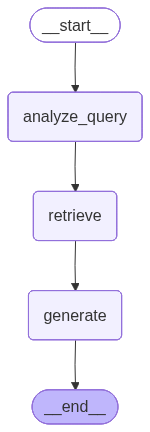

In [45]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition end of post', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='e7bb2dc0-4fcf-46a8-b67d-111696d06149', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 37831, 'section': 'end'}, page_content='"content": "Please now remember the steps:\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nFirst lay out the names of the core classes, functions, methods that will be necessary, As well as a quick comment on their purpose.\\n\\nThen you will output the content of each file including ALL code.\\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\\nFILENAME is the lowercase file name including the file extension,\\nLANG is the markup code block language for the code\'s language, and CODE is the code:\\n\\nFILENAME\\n```LANG\\nCODE\\n```\\n\\nPlease note that t